Marco algunos problemas o dudas de artistas que vi:
Esta fito páez y fito paez. Astor Piazzolla Y Su Conjunto 9, Astor Piazzolla y su Quinteto, Astor Piazzola y su Orquesta. Francisco Fiorentino Y Su Orquestra Tipica. Spinneta Jade? No se quien es. SWF-Rundfunkorchester es una radio creo. Daniel Piazzolla Octet ?
'Roberto Grela y su Cuarteto Tipico',
 'Aníbal Troilo & Su Orquestra Típica',
 'Aníbal Troilo & Su Orquesta Típica',
 'Anibal Troilo Y Su Cuarteto',


Creo además que no funciona el cambio de ID, sino que se queda trabado hasta que puede volver a pedirle a la api. Creo que es por el queue. Igual hay artistas que tardan bastante. Tipo 10 min.

In [5]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import json
import re
from multiprocessing import Queue
import networkx as nx
import musicbrainzngs as mb 
import pickle
import numpy as np
import matplotlib.pyplot as plt
import wikipedia as wiki
import time
from unicodedata import normalize

In [6]:
def comparar_strings(string_original, string_a_comparar, porcentaje_aceptado = 1):

    # El porcentaje se determino para que emilia mernes esté en la red
    """
    Recibe:
        string_original: string que se quiere comparar con otro
        string_a_comparar: string con el que se quiere comparar
        porcentaje_aceptado: porcentaje de inclusión del string_original en el string_a_comparar para definir que son igual
    Devuelve:
        comparacion: booleano dependiendo si los strings son porcentualmente iguales o no
        porcentaje: porcentaje igualdad de los strings a comparar
    """

    porcentaje = 0
    comparacion = False
    # Sacamos tildes y dieresis
    trans_tab = dict.fromkeys(map(ord, u'\u0301\u0308'), None)
    string_original = normalize('NFKC', normalize('NFKD', string_original).translate(trans_tab))
    string_a_comparar = normalize('NFKC', normalize('NFKD', string_a_comparar).translate(trans_tab))

    # Sacamos mayusculas y espacios
    string_original, string_a_comparar = string_original.lower().replace(" ", "") , string_a_comparar.lower().replace(" ", "")

    for i, caracter in enumerate(string_a_comparar):
        if (i < len(string_original)) and (caracter == string_original[i]):
            porcentaje += 1
    
    porcentaje = porcentaje/len(string_a_comparar)
    if porcentaje >= porcentaje_aceptado:
        comparacion = True
        
    return comparacion, porcentaje

In [7]:
comparar_strings("Emilía", "éMília Mernés",0.4)

(True, 0.5)

In [8]:
CLIENT_ID = '3a283f4bd64241238d019491e4aedca3'
CLIENT_SECRET = 'aee8c6c05d0a42c487c0069b7bd075a8'

mb.set_useragent('redes_complejas', 0.1) 

def conseguir_id(artista):
    # POST donde le pasamos las clave de la app
    response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': CLIENT_ID, 'client_secret': CLIENT_SECRET})
    # Guardamos el bearer token para usarlo en las peticiones de la API
    access_token = response.json()['access_token']
    headers = {'Authorization': 'Bearer {}'.format(access_token), 'Accept': 'application/json', 'Content-Type': 'application/json'}

    """
    Recibe
        artista: Nombre del artista del cual se quiere su ID
    Devuelve:
        id: La ID del artista
    """
    # End point para obtener los audio features. Esto se saca de la referencia de la documentación
    url = 'https://api.spotify.com/v1/search'

    # Búsqueda. Acá sí hay que pasarselo como parámetros
    params = {'q': f"{artista}", 'type': 'artist', 'limit': '2'}

    # En este caso no lleva ningún parámetro, el id de la canción va directamente en el url
    response = requests.get(url, params = params, headers = headers)

    # Vemos el json de la respuesta
    json_data = response.json()
    
    # Con la siguiente lista conseguimos el ID del primer resultado de la busqueda (creo)
    id = json_data["artists"]["items"][0]["id"]

    return id

# Algunos artistas que deberian estar que sacamos de wikipedia
lista_artistas_provincia = np.load("artistas_por_provincia_wikipedia.npy")
# Lista de provincias para comprobarlas
lista_provincias = ["Argentina","Buenos Aires", "Catamarca", "Chaco", "Chubut", "Córdoba", "Corrientes", "Entre Ríos", "Formosa", "Jujuy", "La Pampa", "La Rioja", "Mendoza", "Misiones", "Neuquén", "Río Negro", "Salta", "San Juan", "San Luis", "Santa Cruz", "Santa Fe", "Santiago del Estero", "Tierra del Fuego", "Tucumán"]

def es_argentino_y_genero(nombre_artista, porcentaje_aceptado = 1): 
    """
    Recibe:
        nombre_artista: nombre del artista a analizar
        porcentaje_aceptado: porcentaje de inclusión del string_original en el string_a_comparar para definir que son igual
    Devuelve:
        es_argentino: booleano definiendo si el artista es argentino
        genero: género no musical del artista
        porcentaje: porcentaje igualdad del nombre en spotify y en musicbrainz
    """
    # Metemos a Argentina en la lista de provincias por las dudas ya que hay artistas que lo tienen
    es_arg = False
    genero = "NA"
    
    data = mb.search_artists(artist = nombre_artista, limit= 1, country = "Argentina", area = "Argentina")
    if nombre_artista in lista_artistas_provincia: # Lo buscamos en nuestra lista de artistas
        es_arg = True

    # Definimos la data del artista acotada para acceder más facil a ella
    data_primer_resultado = data["artist-list"][0]
    # Conseguimos el nombre de musicbrainz del artista
    nombre_artista_musicbrainz = data_primer_resultado["name"]

    # Comparamos los nombres de spotify y de musicbrainz del artista
    comparacion_strings, porcentaje = comparar_strings(nombre_artista, nombre_artista_musicbrainz,porcentaje_aceptado)
    if comparacion_strings:
        if data["artist-count"] != 0: # Lo buscamos en musicbrandz
            if "country" in data_primer_resultado:
                pais = data_primer_resultado["country"]
                if pais == 'AR':
                    es_arg = True
            # Comprobamos las provincias si no está el país
            elif "begin-area" in data_primer_resultado:
                provincia = data_primer_resultado["begin-area"]["name"]
                if provincia in lista_provincias:
                    es_arg = True
            elif "area" in data_primer_resultado:
                # A veces la siguiente linea de donde conseguimos la provincia es Argentina, en ese caso no cambiamos la provincia
                if data_primer_resultado["area"]["name"] != "Argentina": 
                    provincia = data_primer_resultado["area"]["name"]
                    if provincia in lista_provincias:
                        es_arg = True
            
            else: # Lo buscamos en wikipedia
                try:
                    primera_busqueda = wiki.search(nombre_artista)[0]
                    pagina_wiki = wiki.WikipediaPage(primera_busqueda)
                    for categorie in pagina_wiki.categories:
                        if "Argentine" in categorie:
                            es_arg = True
                            break
                except:
                    pass

            if "gender" in data["artist-list"][0]:
                genero = data["artist-list"][0]["gender"]

    return es_arg, genero, porcentaje

# En la siguiente línea se define de donde se saca toda la info, como si este fuera el paquete
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = CLIENT_ID, client_secret=CLIENT_SECRET))

q = Queue()

In [9]:
es_argentino_y_genero("rene perez")

(False, 'NA', 0.4)

In [10]:
client_ids = ['3a283f4bd64241238d019491e4aedca3',"5b52471dd4894ebbbbd0a5b63e33cf63","3a533c6fd3434a29a09896712d5c19bd","14c49fbcea5a4439bfa94aa591089353","8b3a74b411c14db295be20c03a164241","62dad7314da84b22b885bab72e7f2d60","c8a66e35cf214da89054ba73d3c6fa38","78d1a19d9dbd4672a6e404648a02a002", "90eac8c23ced4e508e3c24aa6963e9dd"]
client_secrets = ['aee8c6c05d0a42c487c0069b7bd075a8',"62730cfc96a54bc298c2587228ac147e", "65f9ad113dd54f6091cee7aa5498568b","710e61b1ca974449a6c7a23c50146cca","9078850544c14866b525ab61aa7dfdf2","7a346376cdaf43948b16b436ca62c8a9","88e65321317744a6bad17c0522a63756", "dfebc28a789d44b89ad0fdce779af0e2", "1c8c10c2b9d94934b733b26fd06a3783"]

In [60]:
nombre_artista = "Bizarrap" 
tiempo_inicial = time.time()
index_aut = 0
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = client_ids[index_aut], client_secret=client_secrets[index_aut]))
# Definimos un multigrafo
G = nx.MultiGraph()


# Tags de canciones a revisar
filtros_canciones = ["en vivo","en directo","live from","live"] 

# Artistas que fueron revisados
lista_artistas = [nombre_artista]

# Albumes que fueron revisados
albums_revisados = []
# Canciones que fueron revisadas
canciones_revisadas = []

#Error aceptado de los strings
lista_porcentajes = [0.5]

# Indice inicial de la lista que vamos a recorrer
i = 0
# Corremos un cierto tiempo
minutos = 5
tiempo_de_ejecucion = 60*minutos
while time.time()-tiempo_inicial < tiempo_de_ejecucion:
    try:
        print(lista_artistas[i])
        # Uri es como el id del artista pero para spotipy
        uri = "spotify:artist:" + conseguir_id(lista_artistas[i])
        # Conseguimos los albumes del artista
        results = sp.artist_albums(uri, album_type='album,single', country='AR') # Esto algo filtra tambien
        albums = results['items']
        
        # No se que hace bien todavia 
        while results['next']:
            # Depaginate
            results = sp.next(results)
            albums.extend(results['items'])

        
        real_albums = dict()
        # Hacemos un filtro a los albumes para que sean únicos
        for album in albums:
            # Strip extraneous characters
            name = re.sub(r'\([^)]*\)|\[[^)]*\]', '', album['name']) # remove (Deluxe edition) and [Feat. asdf] tags
            name = re.sub(r'\W','', name).lower().strip() # remove all non-alphanumerical characters
            if name not in real_albums:
                # print('Adding ' + name)
                real_albums[name] = album
                
        # Ciclamos sobre los albumes que son únicos
        for album in real_albums:
            # Chequeamos que no hayamos revisado el album
            if album not in albums_revisados:
                # album es un string con el nombre del album
                fecha_album = real_albums[album]['release_date']
                # Mark album as analyzed
                albums_revisados.append(album)
                # print('\tAlbum: ' + real_albums[album]['name'])

                # Obtenemos las canciones del album
                results = sp.album_tracks(real_albums[album]['id'])
                canciones = results['items']
                while results['next']:
                    results = sp.next(results)
                    canciones.extend(results['items'])

                # Recorremos las canciones
                for cancion in canciones:
                    # Chequeamos no haber revisado la cancion
                    if cancion["name"] not in canciones_revisadas:
                        filtros_pasados = 0
                        for palabra_filtro in filtros_canciones:
                            if palabra_filtro not in cancion["name"].lower():
                                filtros_pasados += 1
                        
                        # Solo corremos todo si la canción pasó todos los filtros
                        if filtros_pasados == len(filtros_canciones):
                            # Guardamos la canción en una lista
                            canciones_revisadas.append(cancion["name"])
                            # Recorremos los artistas de la canción
                            for artist in cancion['artists']:
                                # Chequeamos que no tengan igual uri
                                if artist['uri'] != uri:
                                    # print('\t\t' + artist['name'])
                                    # La siguiente línea no la entiendo bien, pero creo que lo que hace es el time.sleep que haciamos pero mejor
                                    q.put(artist['uri'])
                                    nombre_colaborador = artist['name']
                                    # Calculamos el porcentaje aceptado
                                    porcentaje_aceptado = np.mean(lista_porcentajes)
                                    # Chequeamos nacionalidad, conseguimos genero y porcentaje del colaborador
                                    es_argentino, genero_colaborador, porcentaje_colaborador = es_argentino_y_genero(nombre_colaborador, porcentaje_aceptado)
                                    
                                    if es_argentino:
                                        # Si es argentino me guardo el porcentaje
                                        lista_porcentajes.append(porcentaje_colaborador)
                                        # Antes chequeaba que el uri no esté en el grafo, pero los estamos guardando con el nombre, entonces nunca estaba el nodo en el grafo 
                                        
                                        if (nombre_colaborador not in G) and (nombre_colaborador not in lista_artistas):
                                            # Get detailed description of artist and create node
                                            artist = sp.artist(artist['uri'])
                                            # print(artist)
                                            # Agregamos atributos al nodo
                                            G.add_node(nombre_colaborador, id=artist['uri'], popularidad=artist['popularity'], generos_musicales = artist['genres'], 
                                                        genero = genero_colaborador)
                                            
                                            lista_artistas.append(nombre_colaborador)
                                            # # Try adding artist's image
                                            # if len(artist['images']) > 0:
                                            #     G.node[artist['uri']]['image_url'] = artist['images'][0]['url']
                                            # else:
                                            #     G.node[artist['uri']]['image_url'] = "https://developer.spotify.com/wp-content/uploads/2016/07/icon1@2x.png"
                                    # Count how many collaborations
                                        # Siempre agrego enlace ya que tiene en cuenta el tiempo
                                        G.add_edge(nombre_colaborador, lista_artistas[i], nombre = cancion["name"] ,fecha = fecha_album)
                    
        i += 1
        
    except Exception as e:
        print(e)
        index_aut += 1
        if index_aut == len(client_ids):
            index_aut = 0
        sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = client_ids[index_aut], client_secret=client_secrets[index_aut]))

Bizarrap
Paulo Londra
Trueno
L-Gante


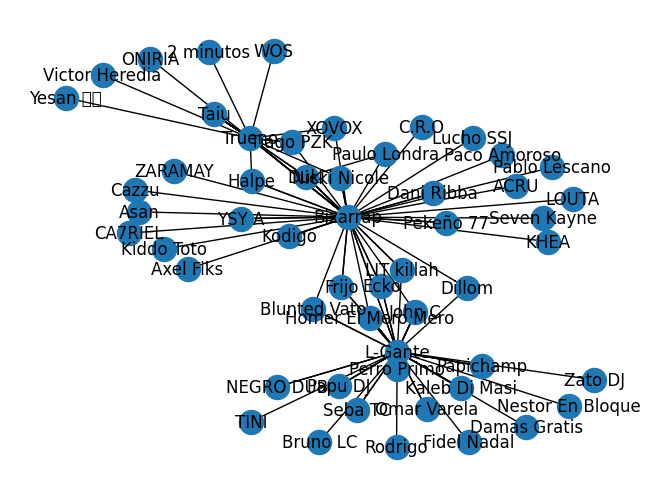

In [63]:
nx.draw(G, with_labels = True)
plt.show()

In [7]:
print(len(lista_artistas))

54


In [8]:
print(len(np.unique(lista_artistas)))

54


Para guardar la red, hay un código en unas celdas más abajo.

Ahora escribo el código para continuar la red desde donde lo dejamos.

In [42]:
# Indice inicial de la lista que vamos a recorrer
i = 644 # ESTE ES EL ÚLTIMO. GUARDE VARIOS ANTES POR LAS DUDAS.

# Cargamos el multigrafo
with open(f"red_final/Iteracion {i}/red_final_hasta_indice_{i}.gpickle", "rb") as f:
    G = pickle.load(f)

# Tags de canciones a revisar
filtros_canciones = ["en vivo","en directo","live from","live"] 

# Artistas que fueron revisados
with open(f'red_final/Iteracion {i}/lista_artistas_argentinos_hasta_indice_{i}.pickle', 'rb') as f:
    lista_artistas = pickle.load(f)
# Albumes que fueron revisados
with open(f'red_final/Iteracion {i}/albums_revisados_hasta_indice_{i}.pickle', 'rb') as f:
    albums_revisados = pickle.load(f)
# Canciones que fueron revisadas
with open(f'red_final/Iteracion {i}/canciones_revisadas_hasta_indice_{i}.pickle', 'rb') as f:
    canciones_revisadas = pickle.load(f)

#Error aceptado de los strings
with open(f'red_final/Iteracion {i}/lista_porcentajes_hasta_indice_{i}.pickle', 'rb') as f:
    lista_porcentajes = pickle.load(f)

In [34]:
with open(f'red_final/Iteracion {66}/lista_artistas_argentinos_hasta_indice_{66}.pickle', 'rb') as f:
    lista_artistas = pickle.load(f)
print(lista_artistas)

['Bizarrap', 'Paulo Londra', 'Trueno', 'L-Gante', 'Pablo Lescano', 'Tiago PZK', 'Duki', 'Nicki Nicole', 'YSY A', 'Asan', 'ACRU', 'KHEA', 'Seven Kayne', 'Cazzu', 'ZARAMAY', 'Homer El Mero Mero', 'LIT killah', 'C.R.O', 'Lucho SSJ', 'Dani Ribba', 'Pekeño 77', 'LOUTA', 'Frijo', 'John C', 'CA7RIEL', 'Kiddo Toto', 'Dillom', 'Kodigo', 'Blunted Vato', 'Paco Amoroso', 'Axel Fiks', 'Halpe', 'Ecko', 'XOVOX', 'Victor Heredia', 'Taiu', 'Yesan 雪山', 'ONIRIA', 'WOS', '2 minutos', 'NEGRO DUB', 'Kaleb Di Masi', 'Omar Varela', 'Papichamp', 'Perro Primo', 'Rodrigo', 'TINI', 'Nestor En Bloque', 'Fidel Nadal', 'Damas Gratis', 'Papu DJ', 'Bruno LC', 'Zato DJ', 'Seba TC', 'Rusherking', 'Maria Becerra', 'FMK', 'Emilia', 'Emkier', 'Lara91k', 'Rei', 'Obie Wanshot', 'Neo Pistea', 'CLUB HATS', 'Marcianos Crew', 'MYA', 'Vicentico', 'La Bomba de Tiempo', 'Chulu', 'Dante Spinetta', 'Sixto Yegros', 'Panther', 'Amelita Baltar', 'KAKTOV', 'Veeyam', 'Axel Caram', 'Maia Reficco', 'Chita', 'La Duraca', 'Mechi Pieretti', 'L

In [22]:
tiempo_inicial = time.time()
index_aut = 4
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = client_ids[index_aut], client_secret=client_secrets[index_aut]))


# Corremos un cierto tiempo
minutos = 50
tiempo_de_ejecucion = 60*minutos
while time.time()-tiempo_inicial < tiempo_de_ejecucion:
    try:
        print(lista_artistas[i])
        # Uri es como el id del artista pero para spotipy
        uri = "spotify:artist:" + conseguir_id(lista_artistas[i])
        # Conseguimos los albumes del artista
        results = sp.artist_albums(uri, album_type='album,single', country='AR') # Esto algo filtra tambien
        albums = results['items']
        
        # No se que hace bien todavia 
        while results['next']:
            # Depaginate
            results = sp.next(results)
            albums.extend(results['items'])

        
        real_albums = dict()
        # Hacemos un filtro a los albumes para que sean únicos
        for album in albums:
            # Strip extraneous characters
            name = re.sub(r'\([^)]*\)|\[[^)]*\]', '', album['name']) # remove (Deluxe edition) and [Feat. asdf] tags
            name = re.sub(r'\W','', name).lower().strip() # remove all non-alphanumerical characters
            if name not in real_albums:
                # print('Adding ' + name)
                real_albums[name] = album
                
        # Ciclamos sobre los albumes que son únicos
        for album in real_albums:
            # Chequeamos que no hayamos revisado el album
            if album not in albums_revisados:
                # album es un string con el nombre del album
                fecha_album = real_albums[album]['release_date']
                # Mark album as analyzed
                albums_revisados.append(album)
                # print('\tAlbum: ' + real_albums[album]['name'])

                # Obtenemos las canciones del album
                results = sp.album_tracks(real_albums[album]['id'])
                canciones = results['items']
                while results['next']:
                    results = sp.next(results)
                    canciones.extend(results['items'])

                # Recorremos las canciones
                for cancion in canciones:
                    # Chequeamos no haber revisado la cancion
                    if cancion["name"] not in canciones_revisadas:
                        filtros_pasados = 0
                        for palabra_filtro in filtros_canciones:
                            if palabra_filtro not in cancion["name"].lower():
                                filtros_pasados += 1
                        
                        # Solo corremos todo si la canción pasó todos los filtros
                        if filtros_pasados == len(filtros_canciones):
                            # Guardamos la canción en una lista
                            canciones_revisadas.append(cancion["name"])
                            # Recorremos los artistas de la canción
                            for artist in cancion['artists']:
                                # Chequeamos que no tengan igual uri
                                if artist['uri'] != uri:
                                    # print('\t\t' + artist['name'])
                                    # La siguiente línea no la entiendo bien, pero creo que lo que hace es el time.sleep que haciamos pero mejor
                                    q.put(artist['uri'])
                                    nombre_colaborador = artist['name']
                                    # Calculamos el porcentaje aceptado
                                    porcentaje_aceptado = np.mean(lista_porcentajes)
                                    # Chequeamos nacionalidad, conseguimos genero y porcentaje del colaborador
                                    es_argentino, genero_colaborador, porcentaje_colaborador = es_argentino_y_genero(nombre_colaborador, porcentaje_aceptado)
                                    
                                    if es_argentino:
                                        # Si es argentino me guardo el porcentaje
                                        lista_porcentajes.append(porcentaje_colaborador)
                                        # Antes chequeaba que el uri no esté en el grafo, pero los estamos guardando con el nombre, entonces nunca estaba el nodo en el grafo 
                                        
                                        if (nombre_colaborador not in G) and (nombre_colaborador not in lista_artistas):
                                            # Get detailed description of artist and create node
                                            artist = sp.artist(artist['uri'])
                                            # print(artist)
                                            # Agregamos atributos al nodo
                                            G.add_node(nombre_colaborador, id=artist['uri'], popularidad=artist['popularity'], generos_musicales = artist['genres'], 
                                                        genero = genero_colaborador)
                                            
                                            lista_artistas.append(nombre_colaborador)
                                            # # Try adding artist's image
                                            # if len(artist['images']) > 0:
                                            #     G.node[artist['uri']]['image_url'] = artist['images'][0]['url']
                                            # else:
                                            #     G.node[artist['uri']]['image_url'] = "https://developer.spotify.com/wp-content/uploads/2016/07/icon1@2x.png"
                                    # Count how many collaborations
                                        # Siempre agrego enlace ya que tiene en cuenta el tiempo
                                        G.add_edge(nombre_colaborador, lista_artistas[i], nombre = cancion["name"] ,fecha = fecha_album)
                    
        i += 1
        
    except Exception as e:
        print(e)
        index_aut += 1
        if index_aut == len(client_ids):
            index_aut = 0
        sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = client_ids[index_aut], client_secret=client_secrets[index_aut]))

Luis Gaeta
Gabriel Castagna
Dora De Marinis
ALBERTO GINASTERA
Juan Sebastian Delgado
Ruben Lopez Furst
Ignacio López
AnToN KuRT
Scorpio
Marcelo Baraj
Juan Bayon
María Volonté
Rubén Goldín
Juan Darthes
Fena Della Maggiora
Vandera
Rolando Goldman
Ariel Argañaraz
Paula Pomeraniec
Juan Canosa
Esteban Morgado
Damian Bolotin
Leo Genovese
Sofia Rei
Daniel Barenboim
HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)
Daniel Barenboim
HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)
Daniel Barenboim
HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)
Daniel Barenboim
HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)
Daniel Barenboim
HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)
Daniel Barenboim
caused by: [WinError 10054] Se ha forzado la interrupción de una conexión existente por el host remoto


In [30]:
np.unique(lista_artistas)

array(['0-600', '2 minutos', 'ACRU', 'ALBERTO GINASTERA',
       'ALEJANDRO DOLINA', 'ARTIX!', 'Abel Pintos', 'Aca Seca Trio',
       'Actitud Maria Marta', 'Acus', 'Adolfo Carabelli',
       'Adrian Dargelos', 'Adriana Varela', 'Adrián Abonizio',
       'Adrián Iaies', 'Afrosound Choir', 'Agapornis', 'Agos Nisi',
       'Agus Cassano', 'Agustín Bardi', 'Agustín Guerrero', 'Ainda',
       'Alambre Gonzalez', 'Alan Plachta', 'Alberto Castillo',
       'Alberto Cortez', 'Alberto Echagüe', 'Alberto Ginastera',
       'Alberto Marino', 'Alberto Morán', 'Alberto Rojo',
       'Alberto Williams', 'Aldo Calderón', 'Ale Sergi',
       'Alejandro Del Prado', 'Alejandro Franov', 'Alejandro Lerner',
       'Alejandro Manzoni', 'Alejandro Picciano', 'Alex Hoyer',
       'Alfredo Abalos', 'Alfredo Alcón', 'Alfredo De Angelis',
       'Alfredo Gobbi', 'Alfredo Lichter', 'Alfredo Remus',
       'Alfredo Toth', 'Altocamet', 'Amadeo Mandarino', 'Amadeo Monges',
       'Amelita Baltar', 'Americo Belloto

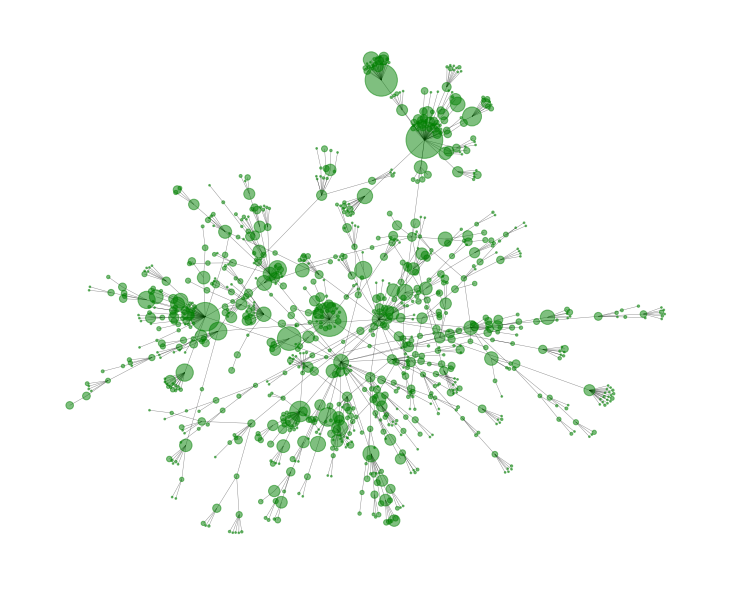

In [24]:
grado = nx.degree(G) #Definimos el grado de la red
lista_nodos = [v[0] for v in grado] # Definimos una lista con los nodos para pasarsela al gráfico junto al tamaño.
tamaño_nodos = [v[1]*3 for v in grado] #definimos el tamaño del nodo como su grado por un factor 3 (factor decidido para mejorar la visualización)

componentes =[G.subgraph(componente) for componente in sorted(nx.connected_components(G), key=len, reverse=True)]  # Ahora aplicamos el algoritmo a las no dirigidas
arbol = nx.minimum_spanning_tree(G, algorithm='kruskal')

plt.figure(figsize = (10,8))
nx.draw(arbol,width = 0.4, alpha = 0.5, nodelist = lista_nodos,node_size=tamaño_nodos,node_color = 'g')
plt.show()

Para guardar la red

In [25]:
pickle.dump(lista_artistas, open(f'lista_artistas_argentinos_hasta_indice_{i}.pickle', 'wb'))
pickle.dump(albums_revisados, open(f'albums_revisados_hasta_indice_{i}.pickle', 'wb'))
pickle.dump(canciones_revisadas, open(f'canciones_revisadas_hasta_indice_{i}.pickle', 'wb'))
pickle.dump(lista_porcentajes, open(f'lista_porcentajes_hasta_indice_{i}.pickle', 'wb'))
#nx.write_gexf(G, f"red_final_hasta_indice_{i}.gexf") #GEPHI NO GUARDA MULTIGRAFOS, QUIZA HABRIA QUE PASARLO A PESADA PARA GUARDARLO
nx.write_gpickle(G, f"red_final_hasta_indice_{i}.gpickle")

Ejemplo de como se agregan los multienlaces

In [38]:
G = nx.MultiGraph()

# Funciona con numeros y strings por igual
G.add_edge("jorge",2, color = "12")
G.add_edge("jorge",2, color = 'messi')

G["jorge"][2]

AtlasView({0: {'color': '12'}, 1: {'color': 'messi'}})

In [39]:
G.degree()

MultiDegreeView({'jorge': 2, 2: 2})

Esto estaba arriba de todo, lo movi porque me molestaba

In [ ]:
def red_colaboradores_artista(nombre_artista, G):
    
    albums_revisados = []
    lista_colaboradores = []
    # Uri es como el id del artista pero para spotipy
    uri = "spotify:artist:" + conseguir_id(nombre_artista)
    # Conseguimos los albumes del artista
    results = sp.artist_albums(uri, album_type='album,single', country='AR')
    albums = results['items']

    # No se que hace bien todavia 
    while results['next']:
        # Depaginate
        results = sp.next(results)
        albums.extend(results['items'])

    # Hacemos un filtro a los albumes para que sean únicos
    real_albums = dict()

    for album in albums:
        
        # Strip extraneous characters
        name = re.sub(r'\([^)]*\)|\[[^)]*\]', '', album['name']) # remove (Deluxe edition) and [Feat. asdf] tags
        name = re.sub(r'\W','', name).lower().strip() # remove all non-alphanumerical characters
        if name not in real_albums:
            # print('Adding ' + name)
            real_albums[name] = album
            real_albums[name+"_fecha"] = album["release_date"]

    # Ciclamos sobre los albumes que son únicos
    for album in real_albums:
        # Chequeamos que no hayamos revisado el album
        if album not in albums_revisados:
            # Mark album as analyzed
            albums_revisados.append(album)
            # print('\tAlbum: ' + real_albums[album]['name'])

            # Obtenemos las canciones del album
            results = sp.album_tracks(real_albums[album]['id'])
            canciones = results['items']
            while results['next']:
                results = sp.next(results)
                canciones.extend(results['items'])

            # Recorremos las canciones
            for cancion in canciones:
                # Recorremos los artistas de la canción
                for artist in cancion['artists']:
                    # Chequeamos que no tengan igual uri
                    if artist['uri'] != uri:
                        # print('\t\t' + artist['name'])
                        # La siguiente línea no la entiendo bien, pero creo que lo que hace es el time.sleep que haciamos pero mejor
                        q.put(artist['uri'])
                        
                        es_argentino, genero_colaborador, porcentaje = es_argentino_y_genero(artist['name'])


                        if artist['uri'] not in G and es_argentino:
                            # Get detailed description of artist and create node
                            artist = sp.artist(artist['uri'])
                                # print(artist)
                            G.add_node(artist['name'], id=artist['uri'], popularidad=artist['popularity'], generos_musicales = artist['genres'], genero = genero_colaborador)
                            lista_colaboradores.append(artist['name'])
                            # # Try adding artist's image
                            # if len(artist['images']) > 0:
                            #     G.node[artist['uri']]['image_url'] = artist['images'][0]['url']
                            # else:
                            #     G.node[artist['uri']]['image_url'] = "https://developer.spotify.com/wp-content/uploads/2016/07/icon1@2x.png"
                        # Count how many collaborations
                            try:
                                G[artist['name']][nombre_artista]['freq'] += 1
                            except KeyError:
                                G.add_edge(artist['name'], nombre_artista, freq=1)
    return lista_colaboradores

def crear_red_ego(nombre_artista,G):
    lista_colaboradores = red_colaboradores_artista(nombre_artista, G)
    # for colaborador in lista_colaboradores:
    #     lista_colaborades_2 = red_colaboradores_artista(colaborador, G)
    #     for colaborador_2 in lista_colaboradores_2:
    #         if colaborador_2 not in lista_colaboradores:
    #             lista_colaboradores.append(colaborador_2)
        
    return G